In [1]:
import numpy as np
import gate
from utils import *
from circuit import *
from decompose import *
from reck import *
from scipy.stats import unitary_group

rand_unitary = unitary_group.rvs

## 1. Tensor product gate

### 1.1 XY gate

In [2]:
xy_prod = np.kron(gate.X.data, gate.Y.data)
print('XY product gate:')
print(xy_prod)

XY product gate:
[[0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]]


In [3]:
# after decomposition
circ = decomp_gate(xy_prod)
opr = circuit_to_unitary(circ)
is_equiv_unitary(xy_prod, opr)

True

### U $\otimes$ I gate

In [4]:
u3_gate = rand_unitary(2, random_state=123)
print('origin U3 paramters:', params_u3(u3_gate)) # period of rotation angle is 2*pi
i_kron_u3 = np.kron(np.identity(2), u3_gate)
circ = decomp_gate(i_kron_u3, return_u3=True) # if return_u3 is True, the circuit can be 
print('is decomposition correct?:', is_equiv_unitary(circuit_to_unitary(circ), i_kron_u3))
disp_circuit(circ)

origin U3 paramters: (2.208653326893343, -5.085970328808669, 0.11715443835178085)
is decomposition correct?: True
                          
q_0: ─────────────────────
     ┌───────────────────┐
q_1: ┤ U3(2.21,1.2,0.12) ├
     └───────────────────┘


## 2. Swap gate

In [5]:
print('origin operator of Swap gate:')
print(gate.Swap.data)

origin operator of Swap gate:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [6]:
circ = decomp_gate(gate.Swap.data)

# results are three CNOT gates
# visualization: use QASM & Qsikit interfaces
disp_circuit(circ)

          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘


## 3. Controlled-U3 gate

### 3.1 CZ gate

In [7]:
cz = gate.CZ.data
circ = decomp_gate(cz, return_u3=True)
is_equiv_unitary(circuit_to_unitary(circ), cz)

True

In [8]:
disp_circuit(circ)

                    
q_0: ───────■───────
     ┌───┐┌─┴─┐┌───┐
q_1: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘


### 3.2 CRz($\pi$) gate

In [9]:
crz = np.kron(np.diag([1,0]), np.identity(2)) + np.kron(np.diag([0,1]), gate.CRz(np.pi).data)
circ = decomp_gate(crz, return_u3=True)
print('is decomposition correct?:', is_equiv_unitary(circuit_to_unitary(circ), crz))
disp_circuit(circ)

is decomposition correct?: True
               ┌───────────┐
q_0: ───────■──┤ Rz(-1.57) ├
     ┌───┐┌─┴─┐└───┬───┬───┘
q_1: ┤ H ├┤ X ├────┤ H ├────
     └───┘└───┘    └───┘    


### 3.2 arbitrary CU3 gate

In [10]:
u3_gate = rand_unitary(2, random_state=123)
cu3 = np.kron(np.diag([1, 0]), np.identity(2)) + np.kron(np.diag([0, 1]), u3_gate)
print(cu3.round(2))

[[ 1.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    1.  +0.j    0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j   -0.4 -0.21j  0.73+0.51j]
 [ 0.  +0.j    0.  +0.j    0.1 -0.89j  0.1 -0.44j]]


In [11]:
# decompose and verification
circ = decomp_gate(cu3, return_u3=True)
print(is_equiv_unitary(circuit_to_unitary(circ), cu3))

True


In [12]:
# visualization
disp_circuit(circ)

                                                   ┌──────────┐  
q_0: ─────────────■──────────────────────────■─────┤ Rz(1.15) ├──
     ┌─────────┐┌─┴─┐┌────────────────────┐┌─┴─┐┌──┴──────────┴─┐
q_1: ┤ Rz(2.6) ├┤ X ├┤ U3(1.1,3.14,-0.66) ├┤ X ├┤ U3(1.1,1.2,0) ├
     └─────────┘└───┘└────────────────────┘└───┘└───────────────┘


## 4. Arbitrary two-qubit gate

In [13]:
u_arb = unitary_group.rvs(4, random_state=123)
print(u_arb.round(3))

[[-0.309+0.628j -0.253+0.39j   0.101+0.533j -0.001-0.009j]
 [-0.165+0.21j   0.564+0.409j -0.584-0.266j  0.05 -0.174j]
 [ 0.36 -0.357j -0.067+0.313j -0.228+0.414j  0.643+0.063j]
 [ 0.425-0.04j  -0.408+0.175j -0.267+0.011j -0.43 -0.604j]]


In [14]:
# decompose and verification
circ = decomp_gate(u_arb, return_u3=True)
print(is_equiv_unitary(circuit_to_unitary(circ), u_arb))

True


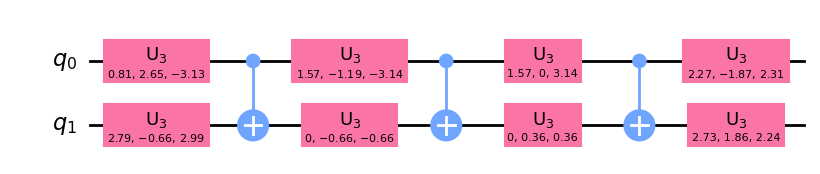

In [15]:
from qiskit import QuantumCircuit
qc = QuantumCircuit.from_qasm_str(to_qasm(circ))
qc.draw('mpl')
# disp_circuit(circ, 'mpl')

**Other: Reck decomposition**

In [16]:
H3 = reduce(np.kron, [gate.H.data] * 3)
params_list, D = reck_decomp(H3)

In [17]:
print(D)

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]


In [18]:
params_list

[(6, 7, 0.7853981633974476, 0, 8),
 (5, 7, 2.1862760354652835, 0, 8),
 (4, 7, 2.0943951023931953, 0, 8),
 (3, 7, 2.0344439357957027, 0, 8),
 (2, 7, 1.9913306620788616, 0, 8),
 (1, 7, 1.183199640139716, 0, 8),
 (0, 7, 1.209429202888189, 0, 8),
 (5, 6, 1.0471975511965954, 0, 8),
 (4, 6, 2.186276035465283, 0, 8),
 (3, 6, 1.1502619915109316, 0, 8),
 (2, 6, 2.0344439357957023, 0, 8),
 (1, 6, 1.9321634507016046, 0, 8),
 (0, 6, 1.183199640139716, 0, 8),
 (4, 5, -2.3561944901923466, 0, 8),
 (3, 5, 1.1831996401397158, 0, 8),
 (2, 5, 1.2094292028881897, 0, 8),
 (1, 5, 1.1071487177940909, 0, 8),
 (0, 5, 1.1502619915109311, 0, 8),
 (3, 4, 1.9321634507016048, 0, 8),
 (2, 4, 1.183199640139716, 0, 8),
 (1, 4, 1.9913306620788616, 0, 8),
 (0, 4, 1.1071487177940909, 0, 8),
 (2, 3, -2.3561944901923453, 0, 8),
 (1, 3, 0.9553166181245096, 0, 8),
 (0, 3, 1.0471975511965974, 0, 8),
 (1, 2, 2.0943951023931953, 0, 8),
 (0, 2, 0.9553166181245093, 0, 8),
 (0, 1, 0.7853981633974488, 0, 8)]